### Zbiór win
https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, roc_auc_score,plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

In [2]:
df=pd.read_csv("winequality-red.csv")

In [3]:
df.shape

(1599, 12)

### Analiza wstępna
- 11 kolumn ze zmiennymi objaśniającymi  (np. zawartość kwasu cytrynowego, gęstość, siarczany, alkohol) 
- kolumna "quality" - target (6 kategorii - od 3 do 8) 
- wszystkie zmienne ją wartościami numerycznymi

### Do sprawdzenia
- sprawdzić czy są wartości NaN lub 0
- określić outliery dla zbioru
- zastanowić się nad przypisaniem nowych kategorii dla targetu 'quality' (czy zmienić na binarne, jeśli tak to jak podzielić)
- zrobić wykresy typu: histogram, boxplot, rozkłady zmiennych
- sprawdzić korelacje


In [4]:
df.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [5]:
#wielkosc grup decyzyjnych
df.quality.value_counts()/sum(df.quality.value_counts())

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


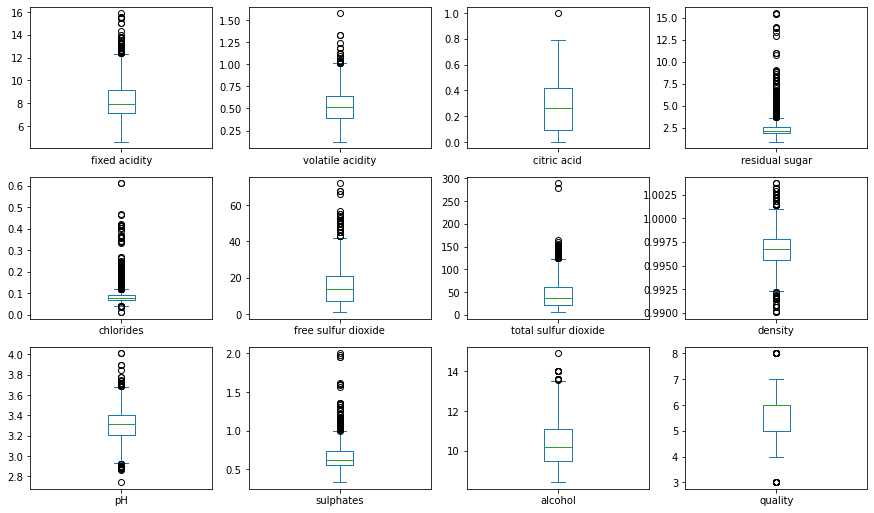

In [7]:
df.plot(kind= 'box', 
        subplots=True, 
        layout=(4,4), 
        figsize=(15,12));

In [8]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [9]:
df.duplicated().sum()

240

In [10]:
df.duplicated()

0       False
1       False
2       False
3       False
4        True
        ...  
1594    False
1595    False
1596     True
1597    False
1598    False
Length: 1599, dtype: bool

In [93]:
#df.drop_duplicates(inplace=True)

In [94]:
df['citric acid'][df['citric acid'] == 0].count()

118

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


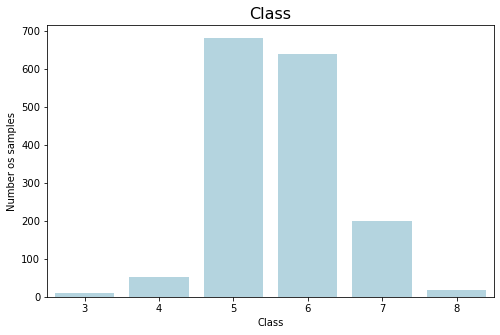

In [12]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x=df['quality'], color='lightblue')
ax.set_title('Class', fontsize=16)
ax.set_xlabel('Class')
ax.set_ylabel('Number os samples')
plt.show()

In [13]:
df.drop(['fixed acidity','residual sugar','chlorides','free sulfur dioxide','pH'], axis=1, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   volatile acidity      1599 non-null   float64
 1   citric acid           1599 non-null   float64
 2   total sulfur dioxide  1599 non-null   float64
 3   density               1599 non-null   float64
 4   sulphates             1599 non-null   float64
 5   alcohol               1599 non-null   float64
 6   quality               1599 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 87.6 KB


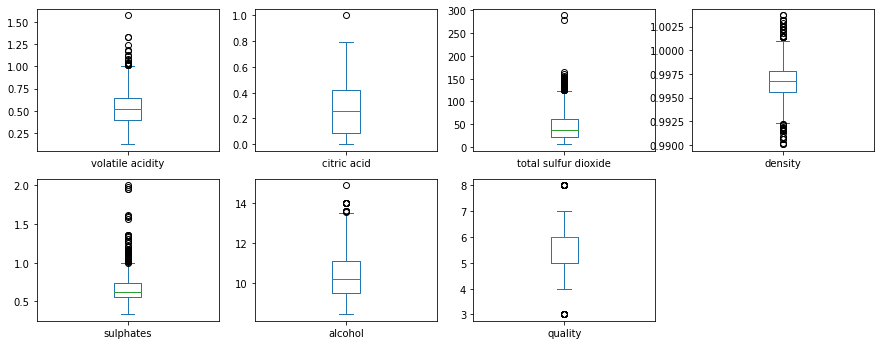

In [15]:
df.plot(kind= 'box', 
        subplots=True, 
        layout=(4,4), 
        figsize=(15,12));

#### Wartość 0 w przypadku kwasu cytrynowego nie jest błędna, jest to uproszczenie stosowane dla  substacji na śladowym poziomie stężenia

In [16]:
columns = ['volatile acidity', 'citric acid', 
         'total sulfur dioxide', 'density',
       'sulphates', 'alcohol','quality']

In [17]:
def rm_out(df):
    df_out = df.copy()
    means, stdevs = {}, {}
    for column in df_out.columns:
        means[column] = df_out[column].mean()
        stdevs[column] = df_out[column].std()
    for column in df_out.columns:
        lower = means[column] - 3 * stdevs[column]
        upper = means[column] + 3 * stdevs[column]
        index = (lower < df_out[column]) & (df_out[column] < upper)
        df_out = df_out[index]
    df_out.index = range(len(df_out))
    return df_out

In [18]:
df_rm = rm_out(df[columns])

In [19]:
df_rm.describe()

,volatile acidity,citric acid,total sulfur dioxide,density,sulphates,alcohol,quality
count,1516.000000,1516.000000,1516.000000,1516.000000,1516.000000,1516.00000,1516.000000
mean,0.522543,0.267328,44.614116,0.996736,0.646003,10.41715,5.658971
std,0.168561,0.192632,30.017891,0.001751,0.134208,1.03176,0.778714
min,0.120000,0.000000,6.000000,0.991500,0.330000,8.40000,4.000000
25%,0.390000,0.090000,22.000000,0.995600,0.550000,9.50000,5.000000
50%,0.520000,0.250000,37.000000,0.996720,0.620000,10.20000,6.000000
75%,0.631250,0.420000,60.000000,0.997800,0.720000,11.10000,6.000000
max,1.040000,0.790000,145.000000,1.002200,1.160000,13.60000,8.000000


In [20]:
df_rm.quality.value_counts()

5    643
6    616
7    192
4     49
8     16
Name: quality, dtype: int64

#### usunięta została kategoria "quality = 3" ale było jej tylko 10 przypadków (0,6%)

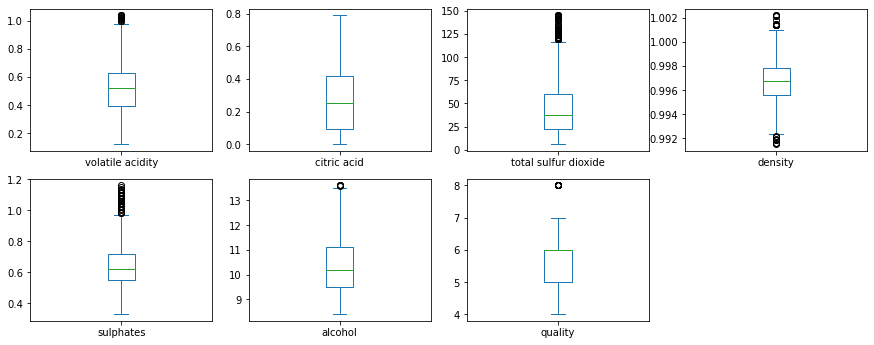

In [21]:
df_rm.plot(kind= 'box' , 
        subplots=True, 
        layout=(4,4), 
        figsize=(15,12));

<AxesSubplot:>

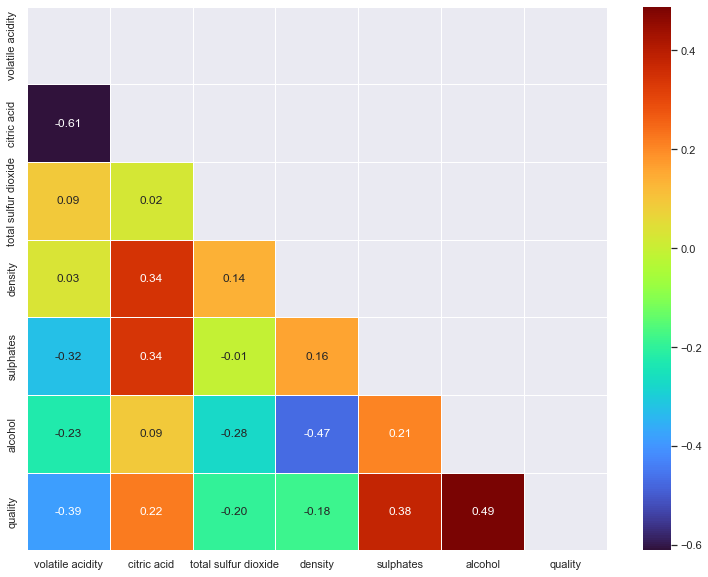

In [106]:
f,ax = plt.subplots(figsize=(13,10))
mask = np.triu(np.ones_like(df.corr(method='spearman')), k=0)
sns.set(font_scale=1)
sns.heatmap(df.corr(method='spearman'), annot=True, linewidths=1, fmt='.2f', ax=ax, cmap="turbo", annot_kws={'fontsize':12}, mask=mask)
  

<AxesSubplot:>

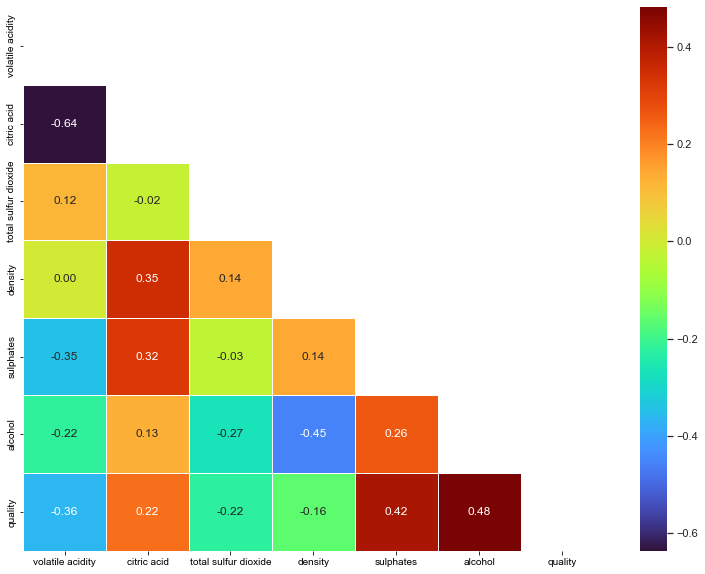

In [22]:
f,ax = plt.subplots(figsize=(13,10))
mask = np.triu(np.ones_like(df_rm.corr(method='spearman')), k=0)
sns.set(font_scale=1)
sns.heatmap(df_rm.corr(method='spearman'), annot=True, linewidths=1, fmt='.2f', ax=ax, cmap="turbo", annot_kws={'fontsize':12}, mask=mask)
  

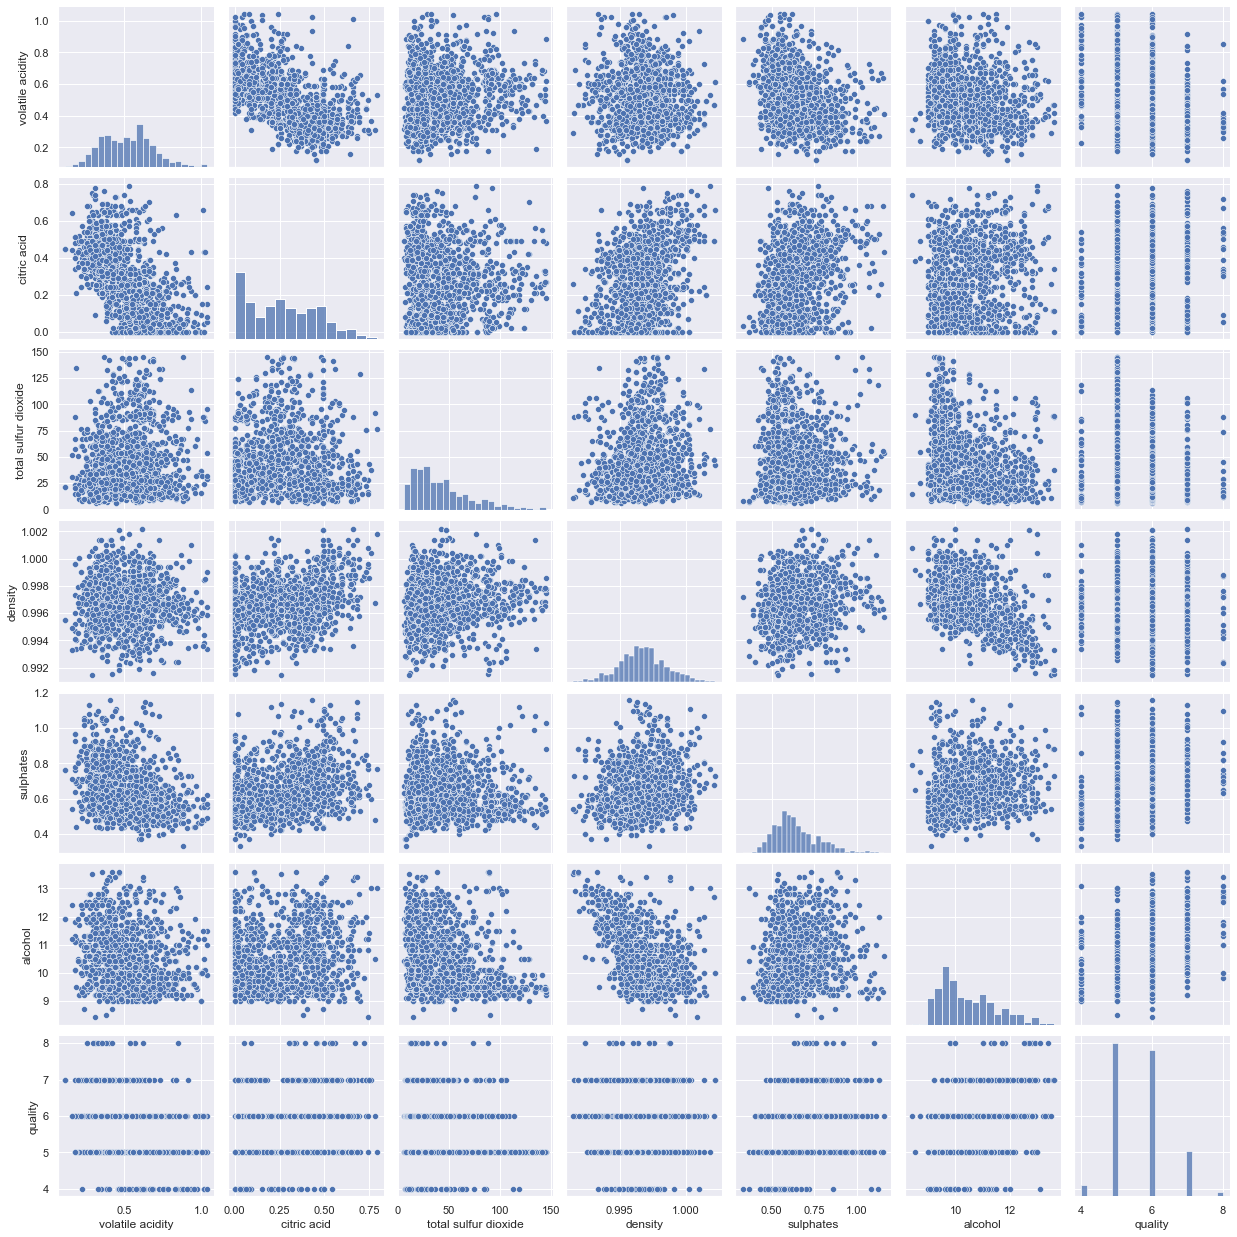

In [23]:
sns.pairplot(df_rm)
pass

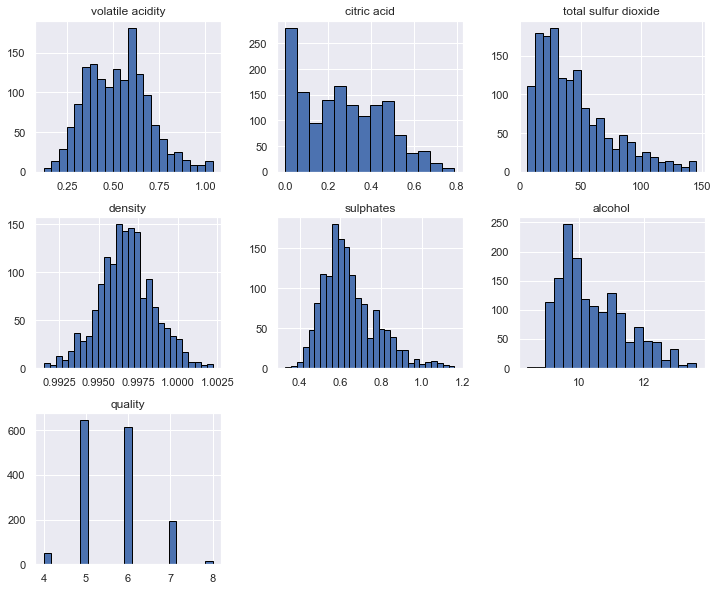

In [24]:
df_rm.hist(bins='auto', edgecolor='black',  
        figsize=(12,10));

In [25]:
df_rm["quality"].value_counts()

5    643
6    616
7    192
4     49
8     16
Name: quality, dtype: int64

In [26]:
df_rm["quality"] = df_rm["quality"].astype(object)

In [27]:
df_rm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   volatile acidity      1516 non-null   float64
 1   citric acid           1516 non-null   float64
 2   total sulfur dioxide  1516 non-null   float64
 3   density               1516 non-null   float64
 4   sulphates             1516 non-null   float64
 5   alcohol               1516 non-null   float64
 6   quality               1516 non-null   object 
dtypes: float64(6), object(1)
memory usage: 83.0+ KB


In [28]:
df_rm.quality.value_counts()

5    643
6    616
7    192
4     49
8     16
Name: quality, dtype: int64

In [29]:
#utworzenie 2 kategorii jakości wina (0 - złe, 1 -dobre)
# 0 - kategorie 3-6, 1 - kategorie 7-8
bins = [2, 6.5, 8]
values = ["bad", "good"]
df_rm["quality"] = pd.cut(df_rm["quality"], bins=bins, labels= values)


In [30]:
df_rm["quality"].unique()

['bad', 'good']
Categories (2, object): ['bad' < 'good']

In [31]:
label_qlt = LabelEncoder()

In [32]:
df_rm["quality"] = label_qlt.fit_transform(df_rm["quality"])

In [33]:
df_rm["quality"].value_counts()

0    1308
1     208
Name: quality, dtype: int64

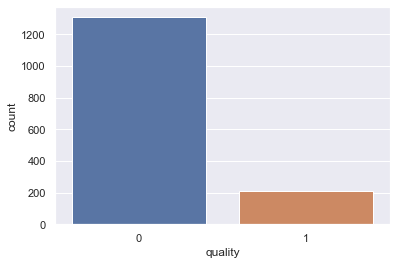

In [34]:
sns.countplot(x ="quality", data = df_rm)
plt.show()

In [35]:
df_rm.shape

(1516, 7)

In [36]:
df_rm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   volatile acidity      1516 non-null   float64
 1   citric acid           1516 non-null   float64
 2   total sulfur dioxide  1516 non-null   float64
 3   density               1516 non-null   float64
 4   sulphates             1516 non-null   float64
 5   alcohol               1516 non-null   float64
 6   quality               1516 non-null   int32  
dtypes: float64(6), int32(1)
memory usage: 77.1 KB


In [37]:
df_rm.to_csv("./df_rm_z_duplikatami.csv", index = False)

In [123]:
X = df_rm.drop("quality", axis=1)
y = df_rm["quality"]

##### Train test split

In [124]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [125]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1033 entries, 1067 to 1126
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   volatile acidity      1033 non-null   float64
 1   citric acid           1033 non-null   float64
 2   total sulfur dioxide  1033 non-null   float64
 3   density               1033 non-null   float64
 4   sulphates             1033 non-null   float64
 5   alcohol               1033 non-null   float64
dtypes: float64(6)
memory usage: 56.5 KB


In [126]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of y_test",y_test.shape)

Shape of X_train:  (1033, 6)
Shape of X_test:  (259, 6)
Shape of y_train:  (1033,)
Shape of y_test (259,)


##### Feature Scaling

In [127]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)